### Solutions to HW 4

This homework assignment will walk you through a simple example of hierarchical Bayesian inference using data from the first Gravitational-Wave Transient Catalog GWTC-1.

We will assume that black hole spin magnitudes are drawn from a *beta distribution $\beta(a,b)$* (which conveniently has support between 0 and 1, the physical range for black hole spin magnitudes). We will fix the parameter $a = 1$ and infer a single population parameter: the $b$ parameter of the beta distribution.

For simplicity, we will neglect gravitational-wave selection effects (which do not strongly depend on spin magnitudes). 

Because our posterior is one-dimensional, we can evaluate the posterior probability density function on a grid.

This repository contains parameter estimation samples downloaded from https://dcc.ligo.org/LIGO-P1800370/public

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np

import scipy.stats as ss

from scipy.integrate import cumtrapz

import glob

import h5py

#### Read in parameter estimation samples from GWTC-1 (first 10 BBHs).

These parameter estimation samples are inferred with an "interim" prior that is flat in the spin magnitude.
Therefore, the posterior on the spin magnitude for each event is proportional to the parameter estimation likelihood, and we can neglect the interim prior.

In [2]:
#list of files containing the parameter estimation samples for all 10 BBH events
PEfiles = glob.glob("GWTC-1_sample_release/*.hdf5")

#initialize empty lists to contain the spin magnitude PE samples for each event
#spin1 is the primary BH's spin, spin2 is the secondary BH's spin in each binary
spin1_allevents = []
spin2_allevents = []

#loop over events
for fname in PEfiles:
    
    with h5py.File(fname, "r") as f:
        
        #read in each event's spin1 and spin2 posterior samples 
        spin1 = np.array(f["Overall_posterior"]["spin1"])
        spin2 = np.array(f["Overall_posterior"]["spin2"])
        
        #append each event's posterior samples array to our lists
        spin1_allevents.append(spin1)
        spin2_allevents.append(spin2)
        

## Problem 1 (10 points):

Plot the parameter estimation spin1 and spin2 posteriors for each event (make a normalized histogram of the parameter estimation samples).

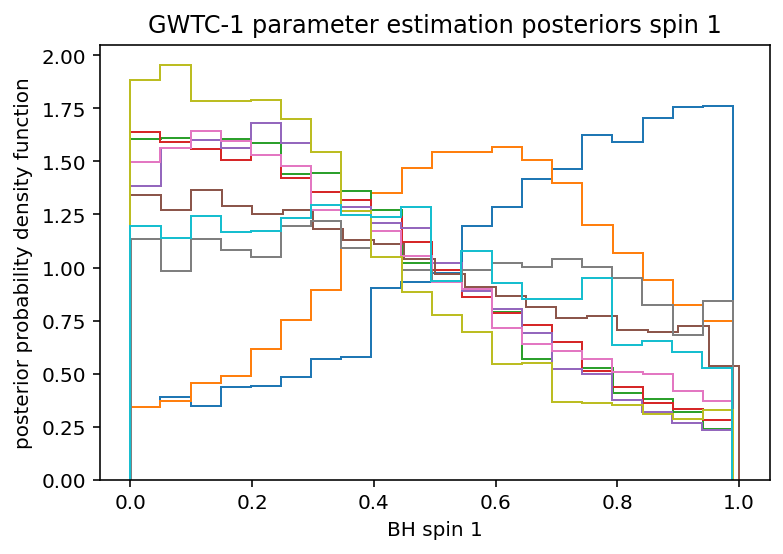

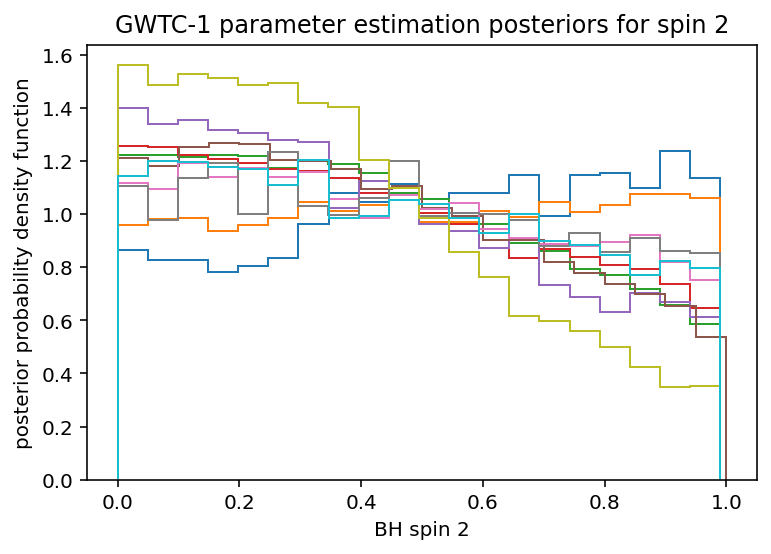

In [3]:
###make plot

for spin1 in spin1_allevents:
    
    plt.hist(spin1, bins = 20, density = True, histtype = 'step')

plt.xlabel('BH spin 1')
plt.ylabel('posterior probability density function')
plt.title('GWTC-1 parameter estimation posteriors spin 1')

plt.show()
    
###repeat for spin2

for spin2 in spin2_allevents:
    
    plt.hist(spin2, bins = 20, density = True, histtype = 'step')
    
plt.xlabel('BH spin 2')
plt.ylabel('posterior probability density function')
plt.title('GWTC-1 parameter estimation posteriors for spin 2')

plt.show()

#### Population model

We consider a population model for BH spins $s_1$ and $s_2$ given by the following probability density function (defined as ```pop_pdf_s1s2``` below):

$$p(s_1, s_2 | b) = \beta(s_1 \mid a = 1, b) \times \beta(s_2 \mid a = 1, b)$$

and $\beta(x \mid a, b)$ is the probability density function of a beta distribution with shape parameters a and b, evaluated at x.

We can evaluate $\beta(x \mid a, b)$ using ```scipy.stats.beta.pdf(x, a, b)```

Here, using the notation from lecture $s_1$ and $s_2$ make up $\theta$, while $b$ plays the role of $\Lambda$.

In [4]:
def pop_pdf_s1s2(s1, s2, b):  
    return ss.beta.pdf(s1, a = 1, b = b) * ss.beta.pdf(s2, a = 1, b = b)

## Problem 2 (10 points):  
To understand how this population model behaves, plot $\beta(x \mid a = 1, b)$ versus $x$ for a few different values of $b$: $b = 1, 1.5, 3, 7$

Text(0, 0.5, 'beta distribution $\\beta(x | a = 1, b = b)$')

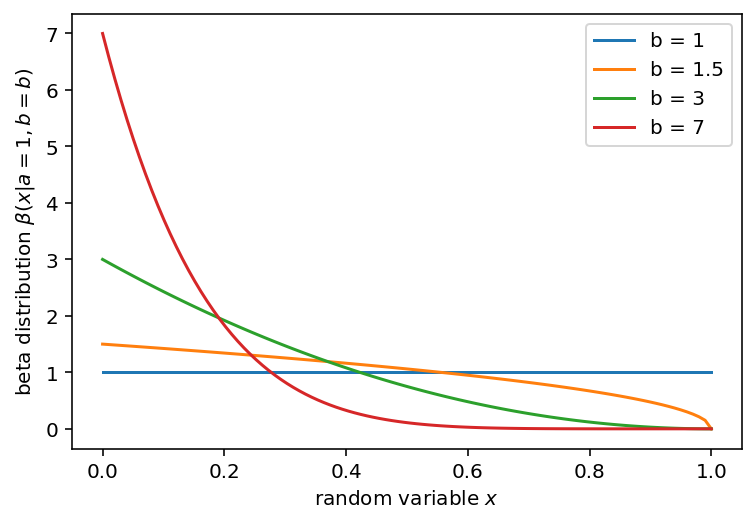

In [5]:
bs = [1, 1.5, 3, 7]

for b in bs:
    x = np.linspace(0, 1, 100)
    y = ss.beta.pdf(x, a = 1, b = b)
    
    plt.plot(x, y, label = f'b = {b}') #complete
    
plt.legend(loc = 'best')

plt.xlabel('random variable $x$')
plt.ylabel(r'beta distribution $\beta(x | a = 1, b = b)$')


#### Hierarchical Bayesian likelihood: single event

We are interested in fitting the parameter $b$ of our population model.

As we discussed in class, for a single event with data $d_i$, the hierarchical Bayesian likelihood, assuming no selection effects, is:
$$
p(d_i \mid b) = \int p(d_i \mid s_1, s_2)p(s_1, s_2 \mid b) ds_1 ds_2
$$

As we also discussed in class, we can approximate the integral as an average over parameter estimation samples, which are draws from the likelihood (this is known as a *Monte Carlo integral*). Note that in general the parameter estimation samples are not drawn from the likelihood, but from the likelihood times a prior. However in this case the parameter-estimation prior is flat, so we can ignore it. In general we have to divide out by the parameter estimation prior.

If we have $N_{PE,i}$ parameter estimation samples for event $i$, our estimate for its single-event likelihood is therefore:

$$
p(d_i \mid b) \approx \frac{1}{N_{PE,i}} \sum_j^{N_{PE, i}} p(s_1^j, s_2^j \mid b)
$$

## Problem 3 (5 pts): 
Fill in the missing terms in the single-event log likelihood function below

In [6]:
def loglikelihood_onesystem(spin1_samples,spin2_samples, b):
    
    return np.log(np.mean(pop_pdf_s1s2(spin1_samples, spin2_samples, b)))

#### Hierarchical Bayesian likelihood: all events

The full likelihood from all 10 of our events is the product of single-event likelihoods
$$
p(\mathbf{d} \mid b) = \prod_i^{10} p(d_i \mid b),
$$

meaning the full log-likelihood is the sum of the single-event log-likelihoods.

In [7]:
def loglikelihood_allsystems(b):
    
    nevents = len(spin1_allevents) #we know this is 10 because we have 10 events, but this way is more general
    
    logL = sum([loglikelihood_onesystem(spin1_allevents[i], spin2_allevents[i], b) for i in range(nevents)])
    
    return logL

## Problem 4 (10 points):

Evaluate this log likelihood on a grid of b values between 1 and 10. Plot the log likelihood as a function of b.

Text(0, 0.5, 'log likelihood $\\log\\mathcal{L}(b)$')

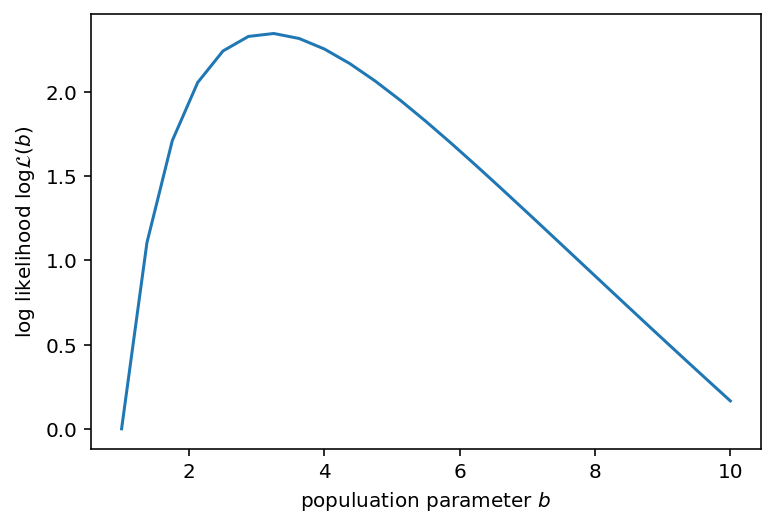

In [8]:
bs = np.linspace(1, 10, 25) #this is a dense enough grid

loglikes = np.zeros_like(bs)

for i, b in enumerate(bs):
    
    loglikes[i] = loglikelihood_allsystems(b)
    
plt.plot(bs, loglikes)

plt.xlabel(r'populuation parameter $b$')

plt.ylabel(r'log likelihood $\log\mathcal{L}(b)$')

## Problem 5 (10 points):
Given a prior $p(b)$, the posterior on $b$ is:
$$
p(b \mid \mathbf{d}) = \frac{p(\mathbf{d} \mid b) p(b) }{\int p(\mathbf{d} \mid b)p(b) db}
$$

Assume a flat prior $p(b) = constant$. 

Plot the (normalized) posterior as a function of $b$

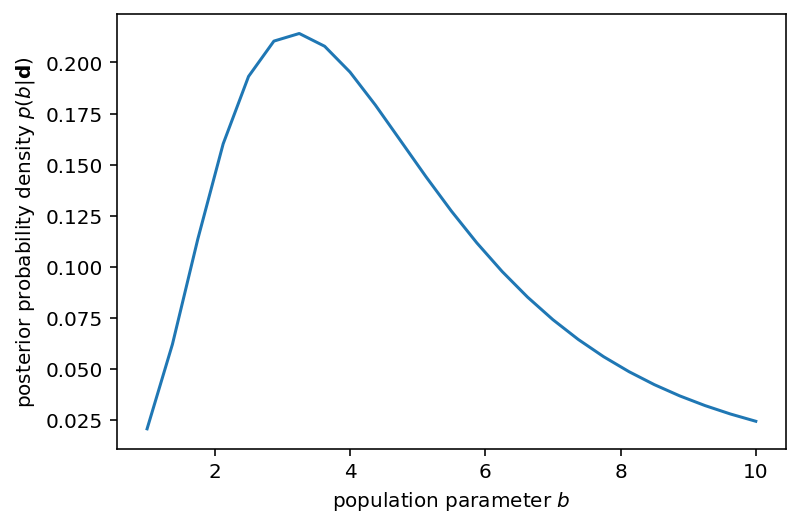

In [9]:
posterior_unnormalized = np.exp(loglikes)

posterior_normalized = posterior_unnormalized / np.trapz(posterior_unnormalized, bs)

plt.plot(bs, posterior_normalized)

plt.xlabel(r'population parameter $b$')

plt.ylabel(r'posterior probability density $p(b | \mathbf{d})$')

plt.show()

## Problem 6 (10 points)

Sample 1000 samples from the posterior on $b$ that you just evaluated in the previous problem using inverse transform sampling.

Make a (normalized) histogram of your 1000 samples to check that they are distributed according to the posterior probability density function you plotted above. 

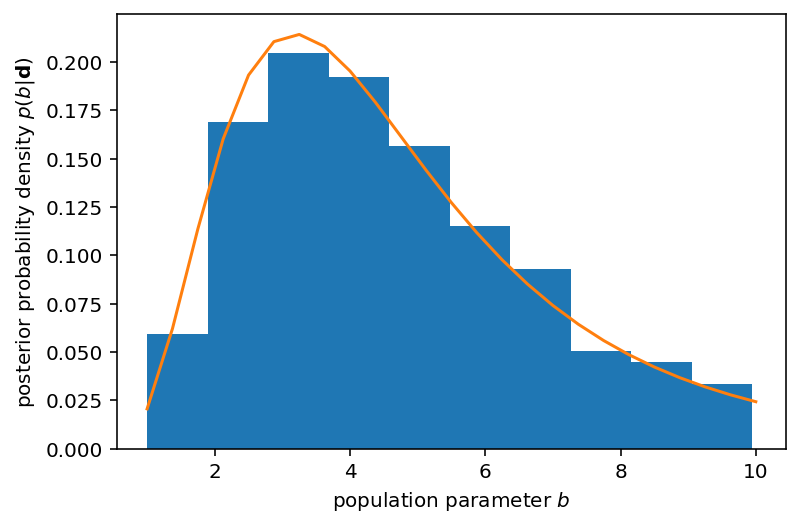

In [10]:
cdf_posterior = cumtrapz(posterior_normalized, bs, initial = 0) #cumulative density function corresponding to posterior probability density function

inverse_cdf = lambda u: np.interp(u, cdf_posterior, bs) #evaluate the inverse cdf function

us = np.random.rand(1000) 

b_post_samples = inverse_cdf(us)

plt.hist(b_post_samples, density = True)

plt.plot(bs, posterior_normalized)

plt.xlabel(r'population parameter $b$')

plt.ylabel(r'posterior probability density $p(b | \mathbf{d})$')

plt.show()

## Problem 7 (5 points)

Plot posterior draws of your inferred spin distribution.

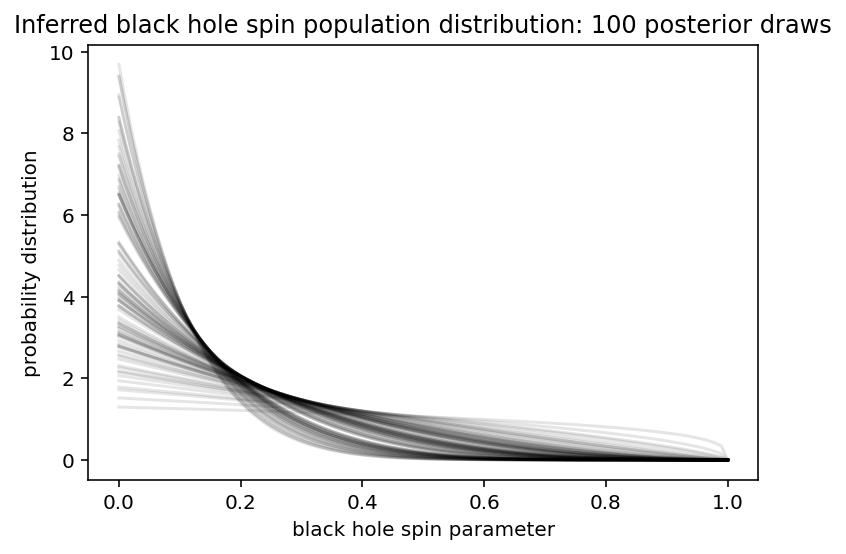

In [11]:
spin = np.linspace(0, 1, 100)

for b in b_post_samples[0:100]: #use first 100 draws, using all 1,000 is overkill
    
    spin_dist = ss.beta.pdf(spin, a = 1, b = b)
    
    plt.plot(spin, spin_dist, alpha = 0.1, c = 'k')
    
plt.xlabel('black hole spin parameter')
plt.ylabel('probability distribution')

plt.title('Inferred black hole spin population distribution: 100 posterior draws')
 
plt.show()